## Notebook to work with interaction dataset merge scenario `DR_CHN_Merging_ZS`
    - Roadway generation
    - Trajdata creation based on reading vehicle tracks from provided csv files

## Changelog
- Friday, Jan 31
    - Creation
    - Toy track generation using way if 10025 from `DR_CHN_Merging_ZS.osm`
- Monday, Feb 3
    - Begin trajdata creation to read in the vehicle tracks. Creation of struct called `INTERACTIONTrajdata`
- Tuesday, Feb 4
    - `Trajdata` reading nominally works. And rendered a scene of course without roadway. Some caveats
        - `car_df_index` line 21 onwards check is commented out
        - No `roadway` involved in the creation of `RecordState`
    - Made a video of replaying the trajdata, of course without roadway, just cars in the blackness
- Wednesday, Feb 5
    - roadway building using `generate_merging_roadway` from `AutonomousMerging.jl`
    - brought in `curevept_overlay` to do overlay the curve points that constitute a road
    - Drove a car in the merging scenario to check that lane semantics works i.e. vehicle understands
    how to keep lane
    - second roadway inspired by William Brannon curved merging lane
- Friday, Feb 7
    - Started pipeline to read Soyeon's centerline data files
    - Generated video replaying interaction dataset on roadways
- Monday, Feb 10
    - Cleanup to prepare for commit to `sisl/AutomotiveInteraction`
- Wednesday, Feb 12
    - Found that the vehicle state needs to have roadway information. Otherwise `observe!` in MOBIL cries
    - This means that we can't initialize the vehicle state the way we have done so far i.e. 
    without providing a `roadway` argument
    - Need to understand `lanes` and `lanetags` and modify roadway creation in terms of how tracks read from
    centerlines txt files into the roadway object
- Friday, Feb 14
    - Got `proj` to work by making `roadway_interaction` in such a way that there are 7 segments, and each segment has only 1 lane. Thus during lane creation, the associated lanetag has `LaneTag(segment_id,1)` as opposed to earlier when the second argument of the LaneTag was going from 1 to 7
- Monday, Feb 17
    - Reorder notebook: make roadway before loading track information
    - function to create the roadway from centerlines called `make_roadway_interaction()` moved to
    `../src/roadway_building.jl`
    - function to read in the vehicle tracks called `read_veh_tracks()` moved to
    `../src/veh_track_reading.jl`
    - Overlayed the vehicle id numbers on the rendered scene using `IDOverlay()`
    - Driven vehicle id 29 using 2D Driver model. Gets stuck at the merge point because lane has
    ended there. Need to fix this
    - Made a new file within `src` called `driving_simulation.jl` to provide simulation functions.
    Moved `get_hallucination_scenes` and `make_def_models` and `run_a_vehicle` into there
    - Roadway recreation for enabling connection at merge point to make vehicle aware of lane
        - Decided that start to end points ordering in txt file should be in direction of travel
        - Separated main lane into until merge point, and after merge point
        - Format of file is now 2 colums with x in col 1 and y in col2. Written using
        `writedlm("filename",coods,',')`
        - 0 has become a, 1 has split into b and then c (direction of travel so b comes first)
        - 2 has become d, 3 has become e
        - 4 has become f, 5 has split into g then h, in direction of travel
        - 6 has become i, and merges at end point of g and then blends into h
- Tuesday, Feb 18
    - Formal roadway creation in progress
    - Major issues with vehicles getting projected to a totally different starting location
    - Wrote function to run multiple vehicles from a starting scene from the real data. Had to bring in
    `keep_vehicle_subset!` to be able to retain a subset of vehicles of interest
    - Roadway issues seem to be fixed. Had to rerun the `read_veh_tracks` for the `traj_interaction` to
    become aware of the updated roadway
    - However, no lane changes even with the most aggressive lane changer `TimLaneChanger`
    - Began lane change investigation in similar roadway to the 3 car tutorial
        - Question is: can cars change lane across segments or do the lanes need to be in the same segment?

In [1]:
# usings
using AutomotiveDrivingModels # Driving simulation platform
using AutoViz # Visualization of roadways and vehicles
using DataFrames # For reading in vehicle tracks into specific type `Trajdata`
using Records # Storing the vehicle tracks in a format that can then be used by `AutomotiveDrivingModels`
using Reel # Make animations of scene visualizations created using `AutoViz`
using DelimitedFiles # Read in centerline txt files into arrays

In [8]:
# Bring functions into notebook: names are self explanatory
include("../src/roadway_building.jl")
include("../src/veh_track_reading.jl")
include("../src/visualization.jl");
include("../src/driving_simulation.jl");

## Build the roadway
- Read centerlines provided in `../dataset`
- functions used (from `AutomotiveInteraction/src/roadway_building.jl)
    - `centerlines_txt2tracks(filename)`, `make_roadway_interaction()`

In [9]:
roadway_interaction = make_roadway_interaction();

## Read vehicle tracks from csv file
- Read vehicle track information provided in `../dataset`
- Functions used (from `AutomotiveInteraction/src/veh_track_reading.jl`)
    - `nframes`, `carsinframe`, `car_df_index`, `read_veh_tracks()`

In [10]:
traj_interaction = read_veh_tracks()

┌ Warning: readtable is deprecated, use CSV.read from the CSV package instead
│   caller = ip:0x0
└ @ Core :-1


Trajdata(3512 frames)

## Investigate lane change possibility: porous boundary

In [22]:
# function: place cars at init location
function init_place_cars(lane_place_array;road_length = 400.0)
    num_lanes = length(lane_place_array)
    roadway = gen_straight_roadway(num_lanes,road_length)
    scene = Scene()

    id = 1
    for i in 1:num_lanes
        for j in 1:length(lane_place_array[i])
            veh_state = VehicleState(Frenet(roadway[LaneTag(1,i)],
                    lane_place_array[i][j][1]),roadway,
                lane_place_array[i][j][2])
            veh = Vehicle(veh_state,VehicleDef(),id)
            push!(scene,veh)
            id+=1
        end
    end
    return scene,roadway
end

init_place_cars (generic function with 1 method)

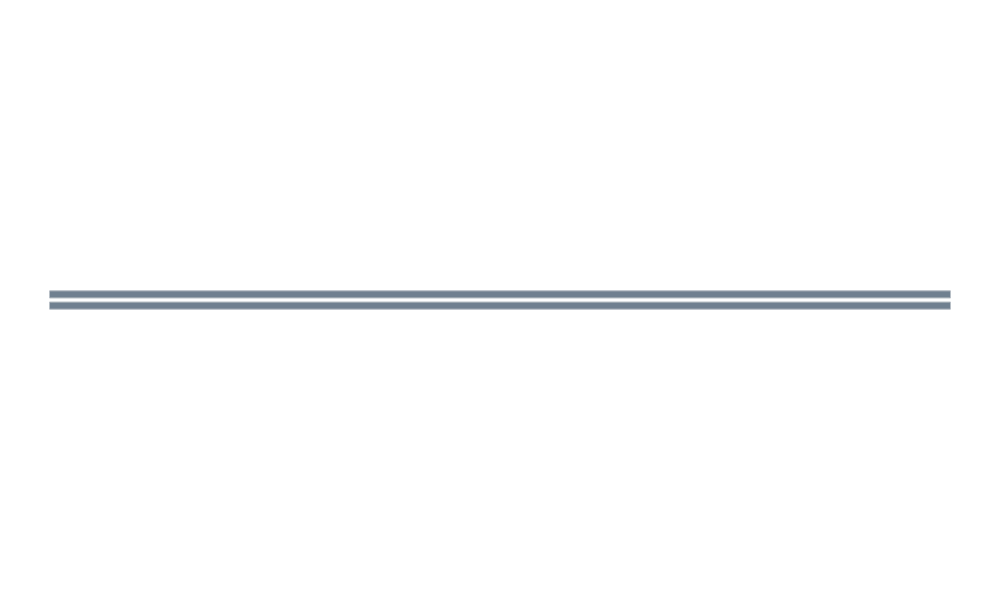

In [38]:
test_road = Roadway()
start1 = VecE2(0.,0.)
end1 = VecE2(400.,0.)
track1 = gen_straight_curve(start1,end1,2)
lane1 = Lane(LaneTag(1,1),track1)
push!(test_road.segments,RoadSegment(1,[lane1]))

start2 = VecE2(0.,5.)
end2 = VecE2(400.,5.)
track2 = gen_straight_curve(start2,end2,2)
lane2 = Lane(LaneTag(2,1),track2)
push!(test_road.segments,RoadSegment(2,[lane2]))

render(test_road)

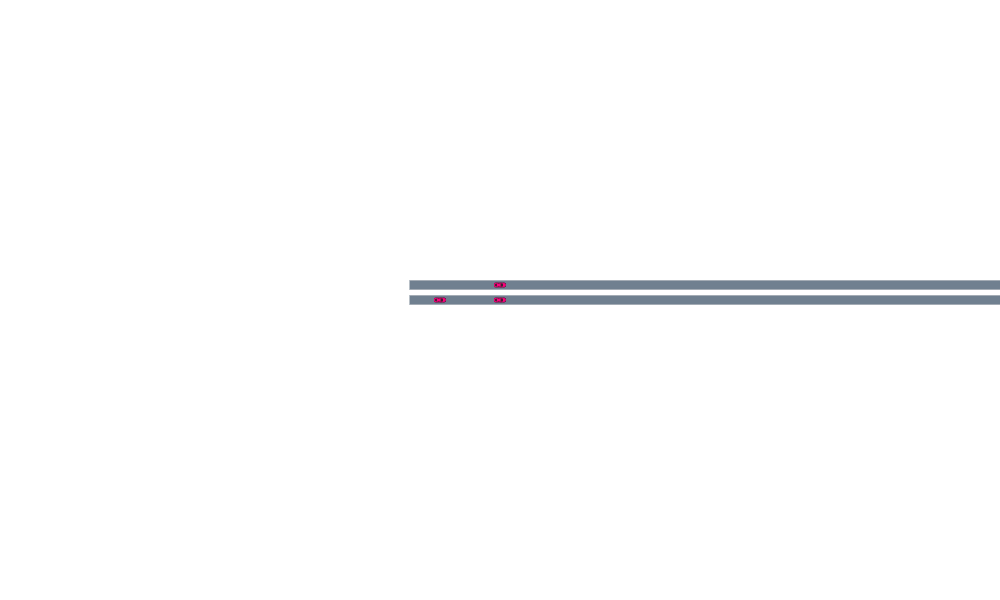

In [39]:
scene = Scene()

veh1 = Vehicle(VehicleState(VecSE2(10.,0.,0.),test_road,20.),VehicleDef(),1)
push!(scene,veh1)

veh2 = Vehicle(VehicleState(VecSE2(30.,0.,0.),test_road,10.),VehicleDef(),2)
push!(scene,veh2)

veh3 = Vehicle(VehicleState(VecSE2(30.,5.,0.),test_road,20.),VehicleDef(),3)
push!(scene,veh3)

models = Dict{Int64,DriverModel}()
for veh in scene
    models[veh.id] = Tim2DDriver(INTERACTION_TIMESTEP)
end

render(scene,test_road,cam=CarFollowCamera(2))

In [40]:
scene_list = get_hallucination_scenes(scene,models = models,id_list = [1,2,3],roadway=test_road);

In [41]:
scenelist2video(scene_list,roadway=test_road,filename="media/no_yaa.mp4")

Making video filename: media/no_yaa.mp4
